In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [9]:
SEED = 20240203
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

def get_filtered_data(is_train=True):
    tf = train_transform if is_train else test_transform
    ds = torchvision.datasets.CIFAR10(root='./data', train=is_train, download=True, transform=tf)


    target_classes = [3, 5, 7, 4]

    mapping = {3: 0, 5: 1, 7: 2, 4: 3}

    indices = [i for i, label in enumerate(ds.targets) if label in target_classes]


    new_targets = np.array(ds.targets)
    for i in indices:
        new_targets[i] = mapping[ds.targets[i]]
    ds.targets = new_targets.tolist()

    return Subset(ds, indices)

train_loader = DataLoader(get_filtered_data(True), batch_size=64, shuffle=True)
test_loader = DataLoader(get_filtered_data(False), batch_size=64, shuffle=False)
class_names = ['cat', 'dog', 'horse', 'deer']

In [19]:
class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # BLOCK 2
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.classifier(x)

In [20]:
def run_train(lr, opt_type='Adam'):
    model = AnimalCNN().to(device)
    criterion = nn.CrossEntropyLoss()

    if opt_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr*2,
                                              steps_per_epoch=len(train_loader),
                                              epochs=20)

    history = []
    for epoch in range(20):
        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Eval
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                _, pred = model(imgs).max(1)
                total += lbls.size(0); correct += pred.eq(lbls).sum().item()

        acc = 100 * correct / total
        history.append(acc)
        print(f"Epoch {epoch+1}/20 | Accuracy: {acc:.2f}%")

    return model, history

In [13]:
print("--- Version 1: Adam (LR=0.001) ---")
model1, hist1 = run_train(0.001, 'Adam')

print("\n--- Version 2: SGD (Option C: Momentum 0.9) ---")
model2, hist2 = run_train(0.001, 'SGD')

--- Version 1: Adam (LR=0.001) ---
Epoch 1/20 | Accuracy: 59.73%
Epoch 2/20 | Accuracy: 65.08%
Epoch 3/20 | Accuracy: 62.40%
Epoch 4/20 | Accuracy: 60.98%
Epoch 5/20 | Accuracy: 69.70%
Epoch 6/20 | Accuracy: 73.00%
Epoch 7/20 | Accuracy: 74.62%
Epoch 8/20 | Accuracy: 77.33%
Epoch 9/20 | Accuracy: 69.47%
Epoch 10/20 | Accuracy: 78.90%
Epoch 11/20 | Accuracy: 79.88%
Epoch 12/20 | Accuracy: 76.75%
Epoch 13/20 | Accuracy: 80.08%
Epoch 14/20 | Accuracy: 81.72%
Epoch 15/20 | Accuracy: 81.72%
Epoch 16/20 | Accuracy: 82.60%
Epoch 17/20 | Accuracy: 83.38%
Epoch 18/20 | Accuracy: 83.10%
Epoch 19/20 | Accuracy: 83.20%
Epoch 20/20 | Accuracy: 83.17%

--- Version 2: SGD (Option C: Momentum 0.9) ---
Epoch 1/20 | Accuracy: 51.67%
Epoch 2/20 | Accuracy: 58.77%
Epoch 3/20 | Accuracy: 63.10%
Epoch 4/20 | Accuracy: 59.92%
Epoch 5/20 | Accuracy: 66.70%
Epoch 6/20 | Accuracy: 67.80%
Epoch 7/20 | Accuracy: 68.25%
Epoch 8/20 | Accuracy: 70.00%
Epoch 9/20 | Accuracy: 71.15%
Epoch 10/20 | Accuracy: 71.90%
Epoc

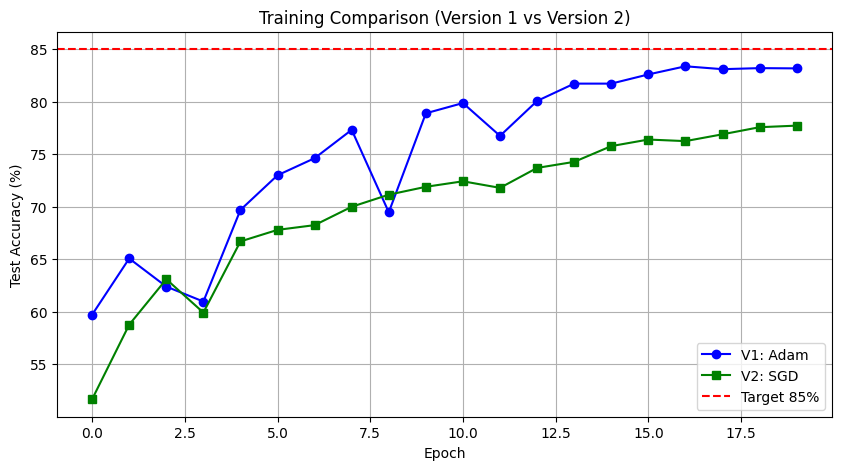

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(hist1, label='V1: Adam', color='blue', marker='o')
plt.plot(hist2, label='V2: SGD', color='green', marker='s')
plt.axhline(y=85, color='red', linestyle='--', label='Target 85%')
plt.title('Training Comparison (Version 1 vs Version 2)')
plt.xlabel('Epoch'); plt.ylabel('Test Accuracy (%)'); plt.legend(); plt.grid()
plt.show()

In [15]:
print(f"\n{'Version':<15} | {'Final Accuracy':<15}")
print("-" * 35)
print(f"{'Version 1':<15} | {hist1[-1]:.2f}%")
print(f"{'Version 2':<15} | {hist2[-1]:.2f}%")


Version         | Final Accuracy 
-----------------------------------
Version 1       | 83.17%
Version 2       | 77.72%


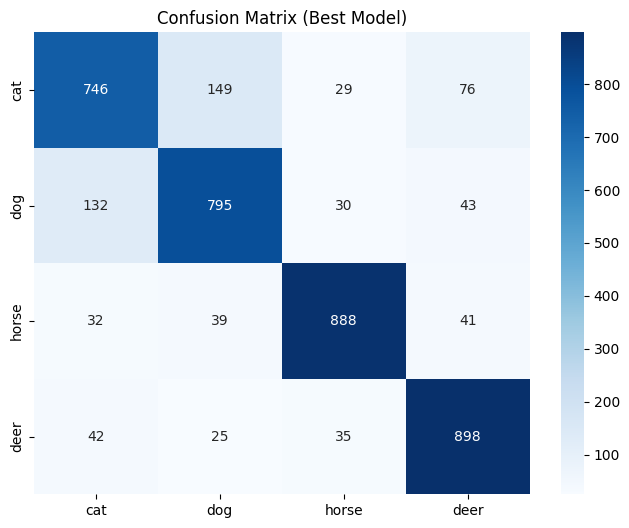

In [16]:
best_model = model1 if hist1[-1] > hist2[-1] else model2
y_true, y_pred = [], []
best_model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        _, pred = best_model(imgs.to(device)).max(1)
        y_true.extend(lbls.numpy()); y_pred.extend(pred.cpu().numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Best Model)'); plt.show()

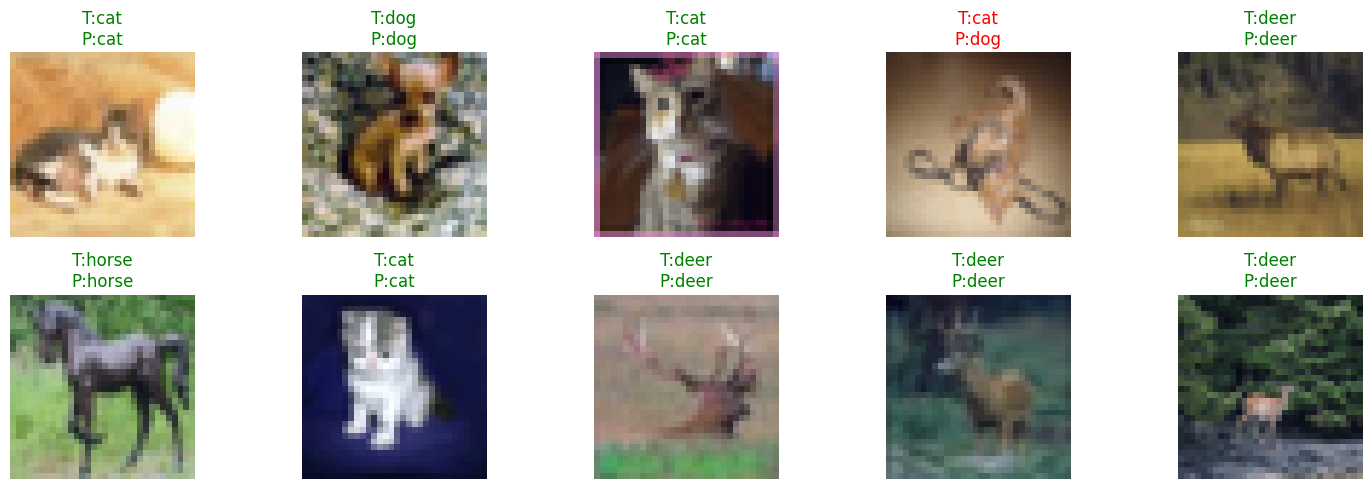

In [17]:
imgs, lbls = next(iter(DataLoader(get_filtered_data(False), batch_size=10, shuffle=True)))
best_model.eval()
with torch.no_grad():
    _, preds = best_model(imgs.to(device)).max(1)

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = np.clip(imgs[i].permute(1, 2, 0).numpy() * 0.2 + 0.5, 0, 1)
    plt.imshow(img); plt.axis('off')
    color = 'green' if preds[i] == lbls[i] else 'red'
    plt.title(f"T:{class_names[lbls[i]]}\nP:{class_names[preds[i]]}", color=color)
plt.tight_layout(); plt.show()